In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import pickle
torch.set_num_threads(1)
import time

def gen_data(alpha, beta, delta, gamma, days, obs_per_day, state0=[2., 1.], linspace=1000, noise=0.03, seed=7):
    nobs = days
    step_size = 1. / (linspace * obs_per_day)
    state_ls = np.ones((days * linspace * obs_per_day, 2))
    state_ls[0] = state0.copy()
    for i in range(1, linspace * days * obs_per_day):
        index = i - 1
        state_ls[i][0] = state_ls[i - 1][0] + step_size * (
                    alpha * state_ls[i - 1][0] - beta * state_ls[i - 1][0] * state_ls[i - 1][1])
        state_ls[i][1] = state_ls[i - 1][1] + step_size * (
                    delta * state_ls[i - 1][0] * state_ls[i - 1][1] - gamma[index]  * state_ls[i - 1][1])
    states = state_ls[::linspace]
    np.random.seed(seed)
    states *= np.random.normal(1, noise, states.shape)
    return np.log(states)

    
plt.rcParams['savefig.dpi'] = 200 #图片像素
plt.rcParams['figure.dpi'] = 200 #分辨率
torch.set_num_threads(1)
n_batch = 100
batch_size = 12
np.random.seed(7)
cp_val = np.random.binomial(1, 0.1, n_batch)
cp_series = np.zeros(0)
for i in range(n_batch):
    if cp_val[i] == 0:
        cp_series = np.concatenate((cp_series, np.zeros(batch_size)), axis=None)
    else:
        np.random.seed(i)
        new_series = np.random.multinomial(1, [1/batch_size] * batch_size)
        cp_series = np.concatenate((cp_series, new_series), axis=None)
        
# construct gamma series
print(cp_series.shape)
discretization=1
obs_per_day=12
total_days = int(5 + n_batch * batch_size / obs_per_day)
print(total_days)
alpha0 = 0.6
beta0 = 0.75 
delta0 = 1. 
# 
MAGI_iter = 15001
gamma_ls = [0.6, 1.0]
gamma = 0.6 * np.ones(60000)
label = 0
for i in range(n_batch * batch_size):
    if cp_series[i]:
        label = 1-label
    val_tmp = gamma_ls[label]
    gamma = np.concatenate((gamma, val_tmp * np.ones(1000)))  

print(gamma.shape)
yobs_np = gen_data(alpha0, beta0, delta0, gamma, total_days, obs_per_day)
cp_series

(1200,)
105
(1260000,)


array([0., 0., 0., ..., 0., 0., 0.])

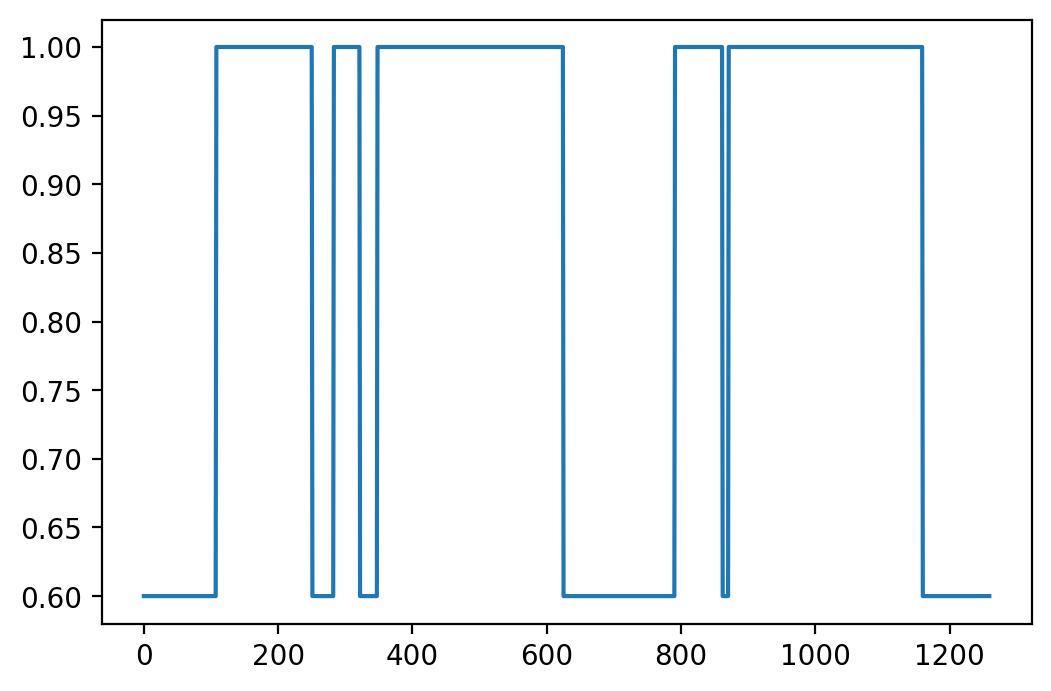

In [4]:
plt.plot(gamma[::1000])

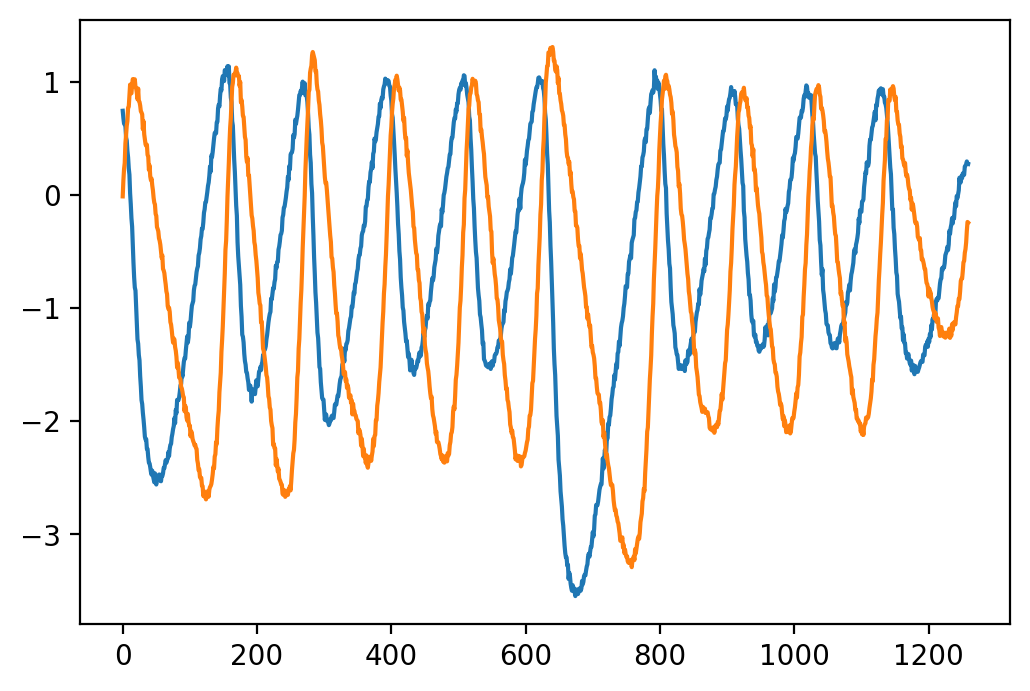

In [5]:
plt.plot(yobs_np[:, 0])
plt.plot(yobs_np[:, 1])

In [6]:
import numpy as np
import torch
import scipy
import argparse
import sys
import matplotlib.pyplot as plt
import matplotlib
from arma import ode_system, solve_magi
from arma import matrix
import time
import pickle
from multiprocessing import Pool

%matplotlib inline
from IPython.core.pylabtools import figsize # import figsize
#figsize(12.5, 4) # 设置 figsize
plt.rcParams['savefig.dpi'] = 200 #图片像素
plt.rcParams['figure.dpi'] = 200 #分辨率
torch.set_num_threads(1)

def fOde(theta, x):
    """
    description of ODE
    theta: list[4]
    return: array(n, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    Rdt = theta[0] - theta[1] * np.exp(fox)
    Fdt = theta[2] * np.exp(rabbit) - theta[3]
    return np.stack([Rdt, Fdt], axis=1)

def fOdeDx(theta, x):
    """
    returns ODE derivation of x given theta
    theta: list[4]
    x: array(n, 2)
    return: array(n, 2, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    resultDx = np.zeros(shape=[np.shape(x)[0], 2, 2])
    # [:, i, j]: jth equation derivative of the ith state
    # (0) / dR
    resultDx[:, 0, 0] = 0
    # (0) / dF
    resultDx[:, 1, 0] =  -theta[1] * np.exp(fox)
    # (1) / dR
    resultDx[:, 0, 1] = theta[2] * np.exp(rabbit)
    # (1) / dF
    resultDx[:, 1, 1] = 0
    return resultDx

def fOdeDtheta(theta, x):
    """
    returns ODE derivation of theta given x
    theta: list[4]
    x: array(n, 2)
    return: array(n, 4, 2)
    """
    resultDtheta = np.zeros(shape=[np.shape(x)[0], 4, 2])
    # [:, i, j]: jth equation derivative of the ith theta
    rabbit = x[:, 0]
    fox = x[:, 1]
    # (0) / 0
    resultDtheta[:, 0, 0] = 1.
    # (0) / 1
    resultDtheta[:, 1, 0] = -np.exp(fox)
    # (1) / 2
    resultDtheta[:, 2, 1] = np.exp(rabbit)
    # (1) / 3
    resultDtheta[:, 3, 1] = -1.
    return resultDtheta

def copy_mat(arma_mat):
    return np.copy(matrix(arma_mat).reshape([-1])).reshape([arma_mat.n_rows, arma_mat.n_cols])

days = 5
discretization = 1
obs_per_day = 12 
theta_lowerbound=np.array([0., 0., 0., 0.])
theta_upperbound=np.array([np.inf, np.inf, np.inf, np.inf])
param_names = ['alpha', 'beta', 'delta', 'gamma']
is_time_varying=[False, False, False, True] 
use_trajectory='inferred'
learning_rate=np.array([1e-4, 1e-3, 1e-5])
n_iter = [15001, 200000, 15000, 200000]
    
yobs = yobs_np[:60]
start_time = time.time()
nobs, p_dim = yobs.shape[0], yobs.shape[1]
n_points = nobs * discretization
theta_dim = theta_lowerbound.shape[0]
d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
for i in range(n_points):
    for j in range(n_points):
        if i > j:
            d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
        else:
            d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
                         thetaLowerBound=theta_lowerbound,
                         thetaUpperBound=theta_upperbound)
tvecObs = np.arange(0, days, 1. / obs_per_day)
tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
yFull = np.ndarray([n_points, p_dim])
yFull.fill(np.nan)
yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
xInitExogenous = np.zeros_like(yFull)
# interpolate: find the ydata of tvecFull given observations
for i in range(p_dim):
    xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])
# First stage: use MAGI package to optimize theta as constant
result = solve_magi(
    yFull,
    Ode_system,
    tvecFull,
    sigmaExogenous=np.array([]),
    phiExogenous=np.array([[]]),
    xInitExogenous=xInitExogenous,
    thetaInitExogenous=np.array([]),
    muExogenous=np.array([[]]),
    dotmuExogenous=np.array([[]]),
    priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
    priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
    priorTemperatureObs=1.0,
    kernel="generalMatern",
    nstepsHmc=100,
    burninRatioHmc=0.5,
    niterHmc=n_iter[0],
    stepSizeFactorHmc=0.01,
    nEpoch=1,
    bandSize=40,
    useFrequencyBasedPrior=True,
    useBand=False,
    useMean=False,
    useScalerSigma=False,
    useFixedSigma=False,
    verbose=True)
samplesCpp = result['samplesCpp']
llikId = 0
xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
# dimension of theta
thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
burnin = int(n_iter[0] * 0.5)
xsampled = samplesCpp[xId, (burnin + 1):]
xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
CovAllDimensionsPyList = []
thetaSampled = samplesCpp[thetaId, (burnin + 1):]
inferred_theta = np.mean(thetaSampled, axis=-1)
sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
inferred_sigma = np.mean(sigmaSampled, axis=-1)
inferred_trajectory = np.mean(xsampled, axis=-1)
for each_gpcov in result['result_solved'].covAllDimensions:
    each_pycov = dict(
        Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
        Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
        mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
    )
    CovAllDimensionsPyList.append(each_pycov)
    
inferred_theta

array([0.61359472, 0.76024636, 0.99157292, 0.59601452])

In [9]:
# Construct theta series
def construct(val, occurence_times, history_value):
    ls = [history_value[int(np.sum(occurence_times)):]]
    for idx in range(occurence_times[0]):
        ls.append(torch.tensor([history_value[-1].item()]))
    for idx in range(occurence_times[1]):
        ls.append(val[0])
    return torch.cat(ls, axis=0).reshape(-1, 1)


# Construct theta series
def calibration_construct(vals, occurence_times_2):
    ls = []
    for idx in range(len(occurence_times_2)):
        for repeat_num in range(occurence_times_2[idx]):
            ls.append(vals[idx])
    return torch.cat(ls, axis=0).reshape(-1, 1)


def update_indicator(history_indicator, idx, batch_size=12):
    cur_val = history_indicator[-1]
    if idx == -1:
        return np.concatenate([history_indicator[batch_size:], cur_val * np.ones(batch_size)])
    return np.concatenate([history_indicator[batch_size:], cur_val * np.ones(idx), (1-cur_val) * np.ones(batch_size-idx)]) 
    


def fOdeTorch(theta, x, constant_param_ls):
    """
    theta: list[4]: beta, ve, vi, pd
    x: array(n, 4)
    r: array(n, 2)
    """
    rabbit = x[:, 0]
    fox = x[:, 1]
    Rdt = constant_param_ls[0] - constant_param_ls[1] * torch.exp(fox)
    Fdt = constant_param_ls[2] * torch.exp(rabbit) - theta[:, 0]
    return torch.stack([Rdt, Fdt], axis=1)


def pointwisethetasigmallikTorch(xlatent, theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature):
    # length of observed y (t)
    n = ydata.shape[0]
    pdimension = ydata.shape[1]
    thetadimension = theta.shape[1]
    sigmaSq = torch.pow(sigma, 2)
    fderiv = fOdeTorch(theta, xlatent, time_constant_param_ls)
    res = torch.zeros([pdimension, 3]).double()
    fitDerivError = torch.zeros([n, pdimension]).double()
    nobs = torch.zeros([pdimension]).double()
    fitLevelErrorSumSq = torch.zeros([pdimension]).double()
    for vEachDim in range(pdimension):
        fitDerivError[:, vEachDim] = fderiv[:, vEachDim]
        fitDerivError[:, vEachDim] -= CovAllDimensionsPyList[vEachDim]['mphi'] @ xlatent[:, vEachDim]
        nobs[vEachDim] = torch.sum(torch.isfinite(ydata[:, vEachDim]))
        obsIdx = torch.isfinite(ydata[:, vEachDim])
        fitLevelErrorSumSq[vEachDim] = torch.sum(torch.square(xlatent[obsIdx, vEachDim] - ydata[obsIdx, vEachDim]))
    res[:, 0] = -0.5 * fitLevelErrorSumSq / sigmaSq - torch.log(sigma + 0.001) * nobs
    res[:, 0] /= priorTemperature[2]
    KinvfitDerivError = torch.zeros([n, pdimension]).double()
    CinvX = torch.zeros([n, pdimension]).double()
    for vEachDim in range(pdimension):
        # inverse of K
        KinvfitDerivError[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Kinv'] @ fitDerivError[:, vEachDim]
        # inverse of Cd
        CinvX[:, vEachDim] = CovAllDimensionsPyList[vEachDim]['Cinv'] @ xlatent[:, vEachDim]
    res[:, 1] = -0.5 * torch.sum(fitDerivError * KinvfitDerivError, dim=0) / priorTemperature[0]
    #  prior distriobution of X
    res[:, 2] = -0.5 * torch.sum(xlatent * CinvX, dim=0) / priorTemperature[1]
    return torch.sum(res), res.detach().numpy()


def new_likelihood(xlatent, vals, occurence_times, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch, priorTemperature, history_value):
    new_theta = construct(vals, occurence_times, history_value)
    return pointwisethetasigmallikTorch(xlatent, new_theta, time_constant_param_ls, sigma, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature)

result_ls = []
cpd_ls = []
latentx_ls = []
history_value = torch.tensor(inferred_theta[3] * np.ones(days * obs_per_day))
history_indicator = np.zeros(days * obs_per_day)
# for each new batch
for EachBatch in range(n_batch):
    print('Batch ' + str(EachBatch))
#     theta_lowerbound=np.array([0., 0., 0., 0.])
#     theta_upperbound=np.array([np.inf, np.inf, np.inf, np.inf])
#     param_names = ['alpha', 'beta', 'delta', 'gamma']
#     is_time_varying=[False, False, False, True] 
#     use_trajectory='inferred'
#     days = 5
    
#     start_time = time.time()
#     nobs, p_dim = yobs.shape[0], yobs.shape[1]
#     n_points = nobs * discretization
#     theta_dim = theta_lowerbound.shape[0]
#     d_matrix = torch.zeros((n_points, n_points), dtype=torch.double)
#     for i in range(n_points):
#         for j in range(n_points):
#             if i > j:
#                 d_matrix[i][j] = (i - j) / (obs_per_day * discretization)
#             else:
#                 d_matrix[i][j] = (j - i) / (obs_per_day * discretization)
#     Ode_system = ode_system("ODE-python", fOde, fOdeDx, fOdeDtheta,
#                              thetaLowerBound=theta_lowerbound,
#                              thetaUpperBound=theta_upperbound)
#     tvecObs = np.arange(0, days, 1. / obs_per_day)
#     tvecFull = np.arange(0, days, 1. / (obs_per_day * discretization))
#     yFull = np.ndarray([n_points, p_dim])
#     yFull.fill(np.nan)
#     yFull[np.arange(0, discretization * nobs, discretization).astype(int), :] = yobs
#     xInitExogenous = np.zeros_like(yFull)
#     # interpolate: find the ydata of tvecFull given observations
#     for i in range(p_dim):
#         xInitExogenous[:, i] = np.interp(tvecFull, tvecObs, yobs[:, i])
#     # First stage: use MAGI package to optimize theta as constant
#     result = solve_magi(
#         yFull,
#         Ode_system,
#         tvecFull,
#         sigmaExogenous=np.array([]),
#         phiExogenous=np.array([[]]),
#         xInitExogenous=xInitExogenous,
#         thetaInitExogenous=np.array([]),
#         muExogenous=np.array([[]]),
#         dotmuExogenous=np.array([[]]),
#         priorTemperatureLevel=yFull.shape[0] / yobs.shape[0],
#         priorTemperatureDeriv=yFull.shape[0] / yobs.shape[0],
#         priorTemperatureObs=1.0,
#         kernel="generalMatern",
#         nstepsHmc=100,
#         burninRatioHmc=0.5,
#         niterHmc=MAGI_iter,
#         stepSizeFactorHmc=0.01,
#         nEpoch=1,
#         bandSize=40,
#         useFrequencyBasedPrior=True,
#         useBand=False,
#         useMean=False,
#         useScalerSigma=False,
#         useFixedSigma=False,
#         verbose=True)
#     samplesCpp = result['samplesCpp']
#     llikId = 0
#     xId = range(np.max(llikId) + 1, np.max(llikId) + yFull.size + 1)
#     # dimension of theta
#     thetaId = range(np.max(xId) + 1, np.max(xId) + theta_dim + 1)
#     sigmaId = range(np.max(thetaId) + 1, np.max(thetaId) + yFull.shape[1] + 1)
#     burnin = int(MAGI_iter * 0.5)
#     xsampled = samplesCpp[xId, (burnin + 1):]
#     xsampled = xsampled.reshape([yFull.shape[1], yFull.shape[0], -1])
#     CovAllDimensionsPyList = []
#     thetaSampled = samplesCpp[thetaId, (burnin + 1):]
#     inferred_theta_2 = np.mean(thetaSampled, axis=-1)
#     print(inferred_theta_2)
#     sigmaSampled = samplesCpp[sigmaId, (burnin + 1):]
#     inferred_sigma = np.mean(sigmaSampled, axis=-1)
#     inferred_trajectory = np.mean(xsampled, axis=-1)
#     for each_gpcov in result['result_solved'].covAllDimensions:
#         each_pycov = dict(
#             Cinv=torch.from_numpy(matrix(each_gpcov.Cinv)).double(),
#             Kinv=torch.from_numpy(matrix(each_gpcov.Kinv)).double(),
#             mphi=torch.from_numpy(matrix(each_gpcov.mphi)).double(),
#         )
#         CovAllDimensionsPyList.append(each_pycov)    
    yobs = yobs_np[int((EachBatch+1) * batch_size):int((EachBatch+1) * batch_size + days * obs_per_day)]
    sigma_torch = torch.tensor(inferred_sigma, dtype=torch.double)
    time_constant_param_ls = []
    for thetaEachDim in range(theta_dim):
        if is_time_varying[thetaEachDim] == False:
            param_name = param_names[thetaEachDim]
            globals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], dtype=torch.double) # , requires_grad=True
            time_constant_param_ls.append(eval(param_name))
    ydata = torch.from_numpy(yobs).double()
    priorTemperature = torch.tensor([discretization, discretization, 1.0])
    cur_loss = np.inf
    occurence_times = np.array([batch_size, 0])
    lik_ls = np.zeros(batch_size+1)
    val_ls = np.zeros(batch_size+1)
    truncate_pointwise_xlatent_torch_tmp = torch.tensor(ydata, requires_grad=True, dtype=torch.double)
    # try every time stamp
    for EachIter in range(batch_size+1):
        print(EachIter)
        vals_tmp = torch.tensor([[history_value[-1].item()]], requires_grad=True)
        sigma_torch_tmp = sigma_torch.detach().clone()
        pointwise_optimizer = torch.optim.Adam([truncate_pointwise_xlatent_torch_tmp, vals_tmp]+ time_constant_param_ls, lr=1e-4)  #  , weight_decay = 1.0
        pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
        cur_loss_tmp = np.inf
        for epoch in range(100000):
            pointwise_optimizer.zero_grad()
            # compute loss function

            llik, res = new_likelihood(truncate_pointwise_xlatent_torch_tmp, vals_tmp, occurence_times, time_constant_param_ls, sigma_torch_tmp,
                                        ydata, CovAllDimensionsPyList, fOdeTorch, #    
                                        priorTemperature, history_value)
            new_loss = -llik
            if epoch % 1000 == 0:
                print(epoch, new_loss.item())
            if epoch % 200 == 0:
                diff = new_loss.item() - cur_loss_tmp
                if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
                    break
                cur_loss_tmp = new_loss.item()
            new_loss.backward()
            pointwise_optimizer.step()
            pointwise_lr_scheduler.step()
        lik_ls[EachIter] = llik.item()
        val_ls[EachIter] = vals_tmp.detach().numpy()
        occurence_times[0] -= 1
        occurence_times[1] += 1
    print(lik_ls)
#     lik_ls = [348.02767358, 348.08185791, 348.04217176, 348.03952768, 348.08294047,
#  348.24969563, 348.44712185, 348.5247469,  348.60811522, 348.53491274,
#  348.34027356, 348.17640464]
    print(time_constant_param_ls)
    # update history of gamma
    # change point not detected
    if max(lik_ls) - lik_ls[0] <= 20.:
        # update history
        print('No change point!')
        history_indicator = update_indicator(history_indicator, -1)
        splits = np.split(history_indicator,np.where(np.diff(history_indicator))[0]+1)
        occurence_times_2 = np.array([len(i) for i in splits])
        new_vals = torch.tensor(history_value[-1].item() * np.ones(len(occurence_times_2)).reshape(-1,1), requires_grad=True)
        pointwise_optimizer = torch.optim.Adam([truncate_pointwise_xlatent_torch_tmp, new_vals]+ time_constant_param_ls, lr=1e-4)  #  , weight_decay = 1.0
        pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
        cur_loss_tmp = np.inf
        for epoch in range(100000):
            pointwise_optimizer.zero_grad()
            # compute loss function
            new_theta = calibration_construct(new_vals, occurence_times_2)
            llik, res = pointwisethetasigmallikTorch(truncate_pointwise_xlatent_torch_tmp, new_theta, time_constant_param_ls, sigma_torch, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature)
            new_loss = -llik
            if epoch % 1000 == 0:
                print('calibration H0: ', epoch, new_loss.item())
            if epoch % 200 == 0:
                diff = new_loss.item() - cur_loss_tmp
                if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
                    break
                cur_loss_tmp = new_loss.item()
            new_loss.backward()
            pointwise_optimizer.step()
            pointwise_lr_scheduler.step()
                
        history_value = new_theta.detach()[:, 0]
        print(history_value)
        result_ls.append(history_value)
        latentx_ls.append(truncate_pointwise_xlatent_torch_tmp)
        cpd_ls.append(0)
    # change point detected
    else:     
        idx = batch_size - np.argmax(lik_ls)
        print('Change point: ', 60 + idx + EachBatch * batch_size)
        history_indicator = update_indicator(history_indicator, idx)
        splits = np.split(history_indicator,np.where(np.diff(history_indicator))[0]+1)
        occurence_times_2 = np.array([len(i) for i in splits])
        new_vals = torch.tensor(history_value[-1].item() * np.ones(len(occurence_times_2)).reshape(-1,1), requires_grad=True)
        pointwise_optimizer = torch.optim.Adam([truncate_pointwise_xlatent_torch_tmp, new_vals]+ time_constant_param_ls, lr=1e-4)  #  , weight_decay = 1.0
        pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
        cur_loss_tmp = np.inf
        for epoch in range(100000):
            pointwise_optimizer.zero_grad()
            # compute loss function
            new_theta = calibration_construct(new_vals, occurence_times_2)
            llik, res = pointwisethetasigmallikTorch(truncate_pointwise_xlatent_torch_tmp, new_theta, time_constant_param_ls, sigma_torch, ydata, CovAllDimensionsPyList, fOdeTorch,
                                 priorTemperature)
            new_loss = -llik
            if epoch % 1000 == 0:
                print('calibration H1: ', epoch, new_loss.item())
            if epoch % 200 == 0:
                diff = new_loss.item() - cur_loss_tmp
                if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
                    break
                cur_loss_tmp = new_loss.item()
            new_loss.backward()
            pointwise_optimizer.step()
            pointwise_lr_scheduler.step()
                
        history_value = new_theta.detach()[:, 0]
        print(history_value)
        cpd_ls.append(1)
        result_ls.append(history_value)
        latentx_ls.append(truncate_pointwise_xlatent_torch_tmp)

Batch 0
0
0 99709.18379002014


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1000 127.20077995735605
2000 -245.08676362945772
3000 -327.2688643359886
4000 -346.4426499638381
5000 -348.86774998089345
6000 -349.03862704613414
7000 -349.1124895891177
1
0 -349.13299527548656
2
0 -349.0275228564153
3
0 -349.09287768471177
4
0 -348.3427185121452
5
0 -345.9849015403456
1000 -349.4197479893937
6
0 -334.26865760059957
1000 -349.5040813501557
2000 -349.62974430288364
7
0 -317.5339037242421
1000 -349.616733462933
2000 -349.7550532936971
3000 -349.8496883127517
8
0 -306.7092079688624
1000 -349.7361817090824
2000 -349.88139639976777
3000 -349.98786130865494
9
0 -303.8985839898854
1000 -349.82404043351545
2000 -349.9715298625611
3000 -350.07245881402895
10
0 -302.63370595707255
1000 -349.87444960960846
2000 -350.0063324707831
3000 -350.08654145743736
11
0 -307.9400310048637
1000 -349.88095105751677
2000 -349.996991219759
12
0 -315.4895591037599
1000 -349.89243976184673
2000 -350.0021701976899
[349.13299528 349.28465422 349.25899409 349.27220204 349.31219811
 349.45741227 349

In [105]:
tensor([0.5952], dtype=torch.float64, requires_grad=True), tensor([0.7467], dtype=torch.float64, requires_grad=True), tensor([0.9382]

[tensor([0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023,
         0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023,
         0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023,
         0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023,
         0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023,
         0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023,
         0.6023, 0.6023, 0.6023, 0.6023, 0.6023, 0.6023], dtype=torch.float64),
 tensor([0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029,
         0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029,
         0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029,
         0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029,
         0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029, 0.6029,
         0.6029, 0.6029, 0.60

In [16]:
from matplotlib.pyplot import cm
def gen_colors(N):
    values = [int(i*250/N) for i in range(N)]
    # print(values)
    colors=["#%02x%02x%02x"%(200,int(g),40)for g in values] # 250 250 250 ,g值越小越靠近0红色
    return colors

colors = gen_colors(100)
colors

for i in range(n_batch):
    plt.plot(gamma[::1000])
    plt.plot(np.arange(12 * i+12, 12 * i + 72, 1), result_ls[i].numpy(), c=colors[i])
    plt.title('Constant parameter fixed: batch ' + str(i) + '(threshold = 20)')
    plt.ylim(0.4, 1.2)
    plt.savefig('plots/100-param-'+ str(i) + '.png')
    plt.clf()

<Figure size 1200x800 with 0 Axes>

In [11]:
n_batch

100

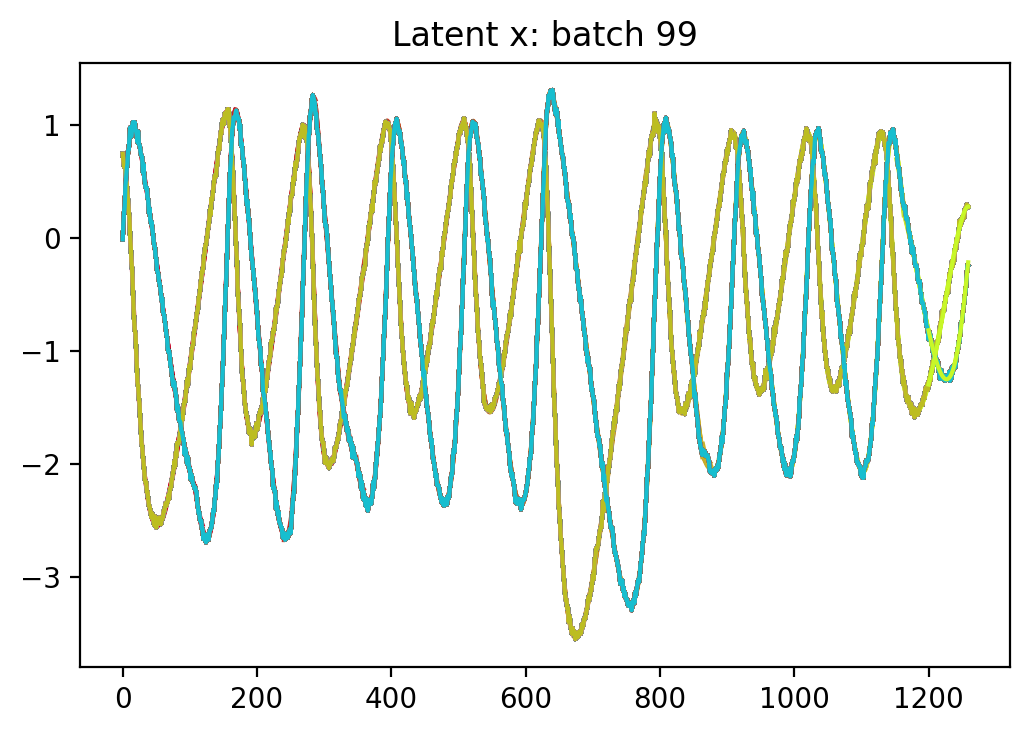

In [14]:
latentx_ls

from matplotlib.pyplot import cm
def gen_colors(N):
    values = [int(i*250/N) for i in range(N)]
    # print(values)
    colors=["#%02x%02x%02x"%(200,int(g),40)for g in values] # 250 250 250 ,g值越小越靠近0红色
    return colors

colors = gen_colors(100)
colors

for i in range(n_batch):
    plt.plot(yobs_np)
    plt.plot(np.arange(12 * i+12, 12 * i + 72, 1), latentx_ls[i].detach().numpy(), c=colors[i])
    plt.title('Latent x: batch ' + str(i))
#     plt.savefig('plots/xlatent-2-'+ str(i) + '.png')
#     plt.clf()

# Generate data, with multiple change points

In [4]:
cp_series

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [7]:
history

ls = [history[:-12]]
for idx in range(occurence_times[0]):
    ls.append(torch.tensor([history[-1].item()]))
for idx in range(occurence_times[1]):
    ls.append(vals_tmp[0])
torch.cat(ls, axis=0).reshape(-1, history.shape[0])

RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [24]:
inferred_trajectory

array([[-2.46522603, -2.44483753, -2.42344485, -2.40100762, -2.37763101,
        -2.35331481, -2.32809588, -2.30204688, -2.27514336, -2.24748899,
        -2.21907003, -2.18991343, -2.16011297, -2.12957296, -2.09836475,
        -2.06650615, -2.0340883 , -2.00104067, -1.967401  , -1.93332706,
        -1.89862436, -1.86346156, -1.82779648, -1.7916436 , -1.75507323,
        -1.7180559 , -1.68060777, -1.64277645, -1.60456416, -1.56598091,
        -1.52704181, -1.48780899, -1.4481823 , -1.40824423, -1.36801822,
        -1.32746601, -1.28664424, -1.24557636, -1.20419972, -1.16259879,
        -1.12074941, -1.07867248, -1.03634503, -0.99382427, -0.95110844,
        -0.90818121, -0.86502695, -0.8216822 , -0.77816496, -0.73446655,
        -0.69057594, -0.64655467, -0.60237395, -0.55803404, -0.51355499,
        -0.46893952, -0.42418072, -0.37929857, -0.33438825, -0.28924474],
       [-0.66655395, -0.70423093, -0.74189977, -0.7795485 , -0.817193  ,
        -0.85485203, -0.89245662, -0.93009169, -0.

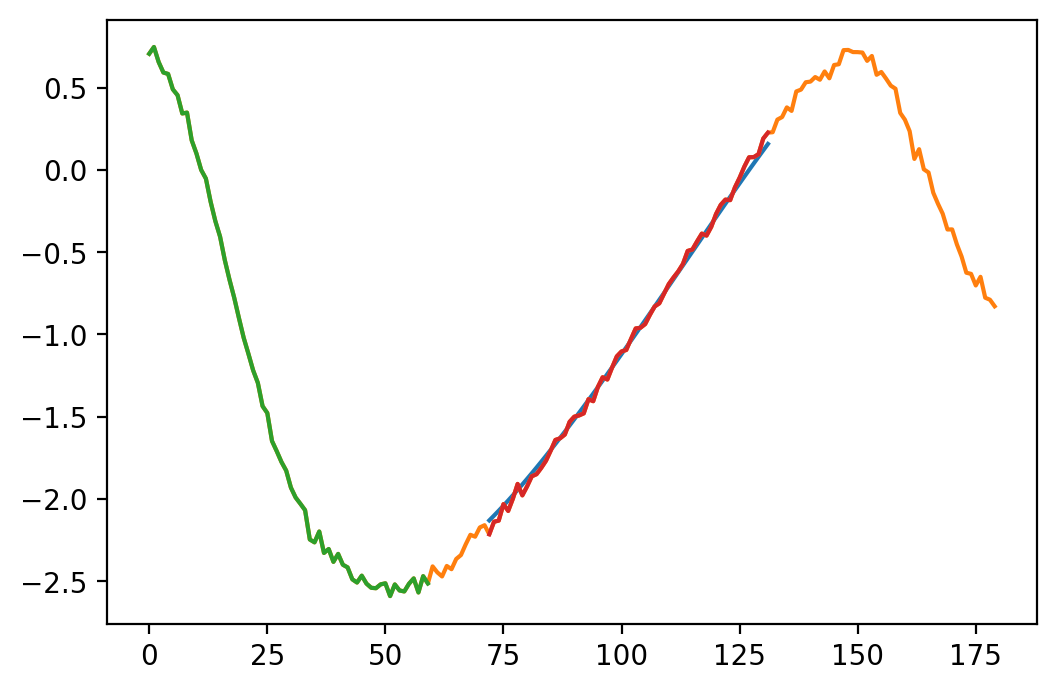

In [12]:
plt.plot(np.arange(72, 132, 1), truncate_pointwise_xlatent_torch_tmp.detach().numpy()[:, 0])

plt.plot(yobs_np[:, 0])
plt.plot(yFull[:, 0])
plt.plot(np.arange(72, 132, 1), yobs[:, 0])
# plt.plot(truncate_pointwise_xlatent_torch_tmp.detach().numpy()[:, 1])
# plt.plot(yobs[:, 1])

In [4]:
n_batch = 50
batch_size = 12
np.random.seed(5)
cp_val = np.random.binomial(1, 0.1, n_batch)
cp_series = np.zeros(0)
for i in range(n_batch):
    if cp_val[i] == 0:
        cp_series = np.concatenate((cp_series, np.zeros(batch_size)), axis=None)
    else:
        np.random.seed(i)
        new_series = np.random.multinomial(1, [1/batch_size] * batch_size)
        cp_series = np.concatenate((cp_series, new_series), axis=None)
        
for i in range(50):
    print(cp_series[i * 12:i * 12 + 12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0.

Text(0.5, 1.0, 'Detected Change Point = 104')

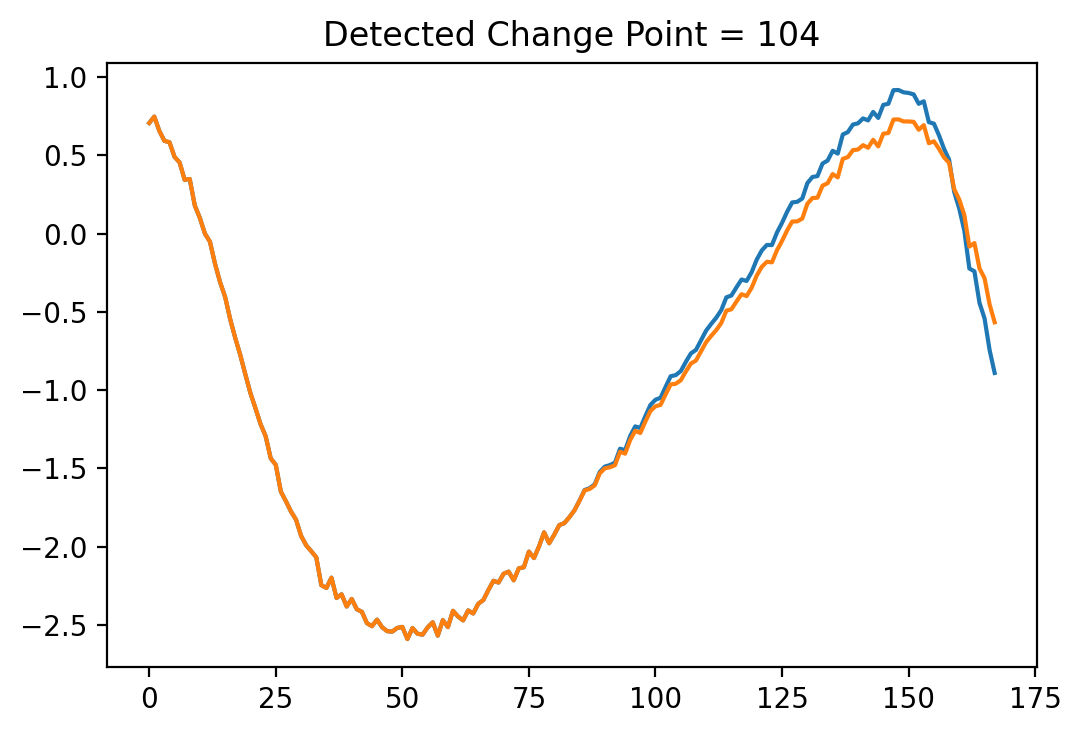

In [13]:
n_batch = 9
batch_size = 12

np.random.seed(5)
cp_val = np.random.binomial(1, 0.2, n_batch)
cp_series = np.zeros(0)
for i in range(n_batch):
    if cp_val[i] == 0:
        cp_series = np.concatenate((cp_series, np.zeros(batch_size)), axis=None)
    else:
        np.random.seed(i)
        new_series = np.random.multinomial(1, [1/batch_size] * batch_size)
        cp_series = np.concatenate((cp_series, new_series), axis=None)
        
        
discretization=1
obs_per_day=12
total_days = int(5 + n_batch * batch_size / obs_per_day)
alpha0 = 0.6
beta0 = 0.75 
delta0 = 1. 
# 
MAGI_iter = 8000
gamma_ls = [0.6, 1.0]
gamma = 0.6 * np.ones(6000)
label = 0
for i in range(n_batch * batch_size):
    if cp_series[i]:
        label = 1-label
    val_tmp = gamma_ls[label]
    gamma = np.concatenate((gamma, val_tmp * np.ones(100)))  
    
yobs_np = gen_data(alpha0, beta0, delta0, gamma, total_days, obs_per_day)



plt.plot(yobs_np[:, 0])
# plt.plot(yobs_np[:, 1])
gamma2 = 0.6 * np.ones(1000000)
yobs_np2 = gen_data(alpha0, beta0, delta0, gamma2, total_days, obs_per_day)
plt.plot(yobs_np2[:, 0])
len(yobs_np2)
plt.title('Detected Change Point = 104')

# Partial code

In [7]:
ydata = torch.from_numpy(yFull).double()

history = torch.tensor(0.6 * np.ones(48))
TV_theta_mean = np.zeros(int(sum(is_time_varying)))
tv_index = 0
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == True:
        TV_theta_mean[tv_index] = inferred_theta[thetaEachDim]
        tv_index += 1
pointwise_xlatent_torch = torch.tensor(inferred_trajectory.transpose(), requires_grad=True, dtype=torch.double)

tmp1 = np.array([TV_theta_mean])
initial_tvtheta = np.repeat(tmp1, pointwise_xlatent_torch.shape[0], axis=0)
pointwise_theta_torch = torch.tensor(initial_tvtheta, requires_grad=True, dtype=torch.double)
sigma_torch = torch.tensor(inferred_sigma, dtype=torch.double)
time_constant_param_ls = []
for thetaEachDim in range(theta_dim):
    if is_time_varying[thetaEachDim] == False:
        param_name = param_names[thetaEachDim]
        globals()[param_name] = torch.tensor([inferred_theta[thetaEachDim]], requires_grad=True, dtype=torch.double) # 
        time_constant_param_ls.append(eval(param_name))

priorTemperature = torch.tensor([discretization, discretization, 1.0])  # ?
cur_loss = np.inf
occurence_times = np.array([12, 0])
lik_ls = np.zeros(12)
val_ls = np.zeros(12)
# try every time stamp
for EachIter in range(12):
    print(EachIter)
#         if EachIter in lik_ls.keys():
#             continue
    vals_tmp = torch.tensor(np.array([[inferred_theta[3]]]), requires_grad=True)
    truncate_pointwise_xlatent_torch_tmp = pointwise_xlatent_torch.detach().clone()
    truncate_pointwise_xlatent_torch_tmp.requires_grad = True
    sigma_torch_tmp = sigma_torch.detach().clone()
    pointwise_optimizer = torch.optim.Adam([truncate_pointwise_xlatent_torch_tmp, vals_tmp] + time_constant_param_ls, lr=1e-4)  # , weight_decay = 1.0
    pointwise_lr_scheduler = torch.optim.lr_scheduler.StepLR(pointwise_optimizer, step_size=5000, gamma=0.5)
    cur_loss_tmp = np.inf
    for epoch in range(100000):
        pointwise_optimizer.zero_grad()
        # compute loss function

        llik, res = new_likelihood(truncate_pointwise_xlatent_torch_tmp, vals_tmp, occurence_times, time_constant_param_ls, sigma_torch_tmp,
                                    ydata, CovAllDimensionsPyList, fOdeTorch, #    
                                    priorTemperature, history)
        new_loss = -llik
        if epoch % 200 == 0:
            print(epoch, new_loss.item())
            diff = new_loss.item() - cur_loss_tmp
            if torch.isnan(new_loss) == False and diff > -0.01 and diff < 0.01:
                break
            cur_loss_tmp = new_loss.item()
        new_loss.backward()
        pointwise_optimizer.step()
        pointwise_lr_scheduler.step()
    lik_ls[EachIter] = llik.item()
    val_ls[EachIter] = vals_tmp.detach().numpy()
    occurence_times[0] -= 1
    occurence_times[1] += 1
print(lik_ls)
# update history of gamma
# change point not detected
if max(lik_ls) - lik_ls[0] <= 3.84:
    # update history
    print('No change point!')
    history = construct(torch.tensor([history[-1]]), [12, 0], history)
else:
    idx = np.argmax(lik_ls)
    print('Change point: ', batch_size - idx + EachBatch * batch_size)
    history = construct(torch.tensor([val_ls[idx]]), [12-idx, idx], history)

0
0 6571.999635979358
200 5970.55200686959
400 5447.9569388777245
600 4958.226757846603
800 4500.646888280952
1000 4074.4103195247862
1200 3678.0998940666627
1400 3310.113929378733
1600 2968.8297573176396
1800 2652.669471094792
2000 2360.1282001674135
2200 2089.787467982998
2400 1840.320071505113
2600 1610.4929168960252
2800 1399.1687261674563
3000 1205.2998744698089


KeyboardInterrupt: 

In [5]:
time_constant_param_ls

[tensor([0.5792], dtype=torch.float64, requires_grad=True),
 tensor([0.6806], dtype=torch.float64, requires_grad=True),
 tensor([0.0963], dtype=torch.float64, requires_grad=True)]

In [41]:
torch.cat([torch.tensor([1,2,3]), torch.tensor([1]),torch.tensor([2])], axis=0)

tensor([1, 2, 3, 1, 2])

In [43]:
a = torch.tensor([1,2,3])
torch.tensor([a[-1]])

tensor([3])

[1, 1, 2, 2, 3]